# Table of Contents
---
- [Setup](#Setup)
- [Initialization Bugs](#Initialization-Bugs)
    - [High Initial Loss](#High-Initial-Loss)
    - [Activation Saturation](#Activation-Saturation)
        - [He Initialization](#He-Initialization)
- [Batch Normalization](#Batch-Normalization)
    - [Side Effects](#Side-Effects)
    - [Inference with BatchNorm](#Inference-with-BatchNorm)
    - [BatchNorm Summary](#BatchNorm-Summary)
- [PyTorch-ify](#PyTorchify)
- [References](#References)

# Setup

In [1]:
import torch
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
c2i = {s:i+1 for i, s in enumerate(chars)}
c2i['.'] = 0
i2c = {i:s for s, i in c2i.items()}
vocab_size = len(i2c)

In [18]:
block_size = 3

def build_dataset(words):
    X, y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = c2i[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
            
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y

random.seed(42)
random.shuffle(words)
train_idx = int(0.8*len(words))
test_idx = int(0.9*len(words))

X_train, y_train = build_dataset(words[:train_idx])
X_dev, y_dev = build_dataset(words[train_idx:test_idx])
X_test, y_test = build_dataset(words[test_idx:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [19]:
n_embed = 10
n_hidden = 200
seed = 2147483647

gen = torch.Generator().manual_seed(seed)
C = torch.randn((vocab_size, n_embed), generator=gen)
w1 = torch.randn((n_embed*block_size, n_hidden), generator=gen)
b1 = torch.randn(n_hidden, generator=gen)
w2 = torch.randn((n_hidden, vocab_size), generator=gen)
b2 = torch.randn(vocab_size, generator=gen)

parameters = [C,w1,b1,w2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [20]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=gen)
    X_batch, y_batch = X_train[idx], y_train[idx]
    
    # forward pass
    emb = C[X_batch]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ w1 + b1
    h = torch.tanh(h_preact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_batch)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # parameter update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.5404
  10000/ 200000: 2.8099
  20000/ 200000: 2.5571
  30000/ 200000: 2.2386
  40000/ 200000: 2.3711
  50000/ 200000: 2.6954
  60000/ 200000: 2.3508
  70000/ 200000: 2.3226
  80000/ 200000: 2.1561
  90000/ 200000: 2.0154
 100000/ 200000: 2.3318
 110000/ 200000: 2.3907
 120000/ 200000: 2.2951
 130000/ 200000: 2.3942
 140000/ 200000: 2.3171
 150000/ 200000: 2.2876
 160000/ 200000: 2.1326
 170000/ 200000: 2.1442
 180000/ 200000: 2.4135
 190000/ 200000: 2.0607


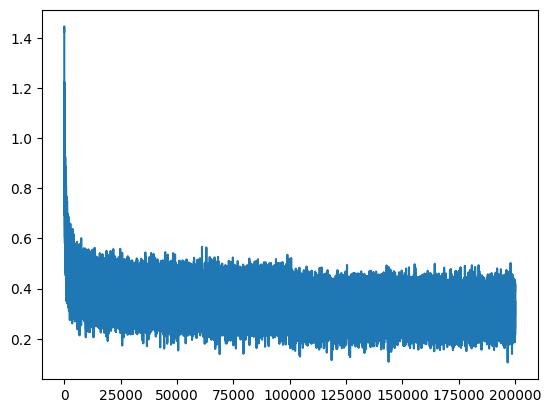

In [21]:
plt.plot(lossi)

In [22]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (X_train, y_train),
        'val': (X_dev, y_dev),
        'test': (X_test, y_test),      
    }[split]
    emb = C[X]
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1189258098602295
val 2.160738468170166


# Initialization Bugs
---
- High initial loss $\to$ due to random weights, biases initialization
- Activation saturation $\to$ weights, biases initialized to extreme values

## High Initial Loss
---
- Weights and biases should be initialized to small values close to zero.
- Biases may be initialized to zero, especially in the last layer, whereas **weights must NEVER be initialized to zero**.
- In our case, the first 10000 steps are spent squashing the initial weights down to reasonable size, rather than optimizing the neural net, which gives us a "hockey-stick" loss curve plot.

In [11]:
exp_init_loss = -torch.tensor(1/27.0).log()
exp_init_loss

tensor(3.2958)

In [28]:
init_loss = 10**lossi[0]
init_loss

26.540439749767614

## Activation Saturation
---
- Most values of the hidden layer are 1 and -1, due to the `tanh` activation.
- In the plot below, each `white` cell indicates a saturated value of hidden layer `h`.
- These saturated values indicate that the gradient calculated during backward pass will be destroyed.
- In the plot below, an entire column of white cells would indicate a `dead` neuron, which means that no single input example activates the `tanh` in its active region.

---
### He Initialization
```python
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')
```
- The resulting tensor will have values sampled from $\mathcal{N} (0, std^2)$ where $$std \ = \ \frac{gain}{\sqrt{fan\_mode}}$$
---
[Kaiming Init](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

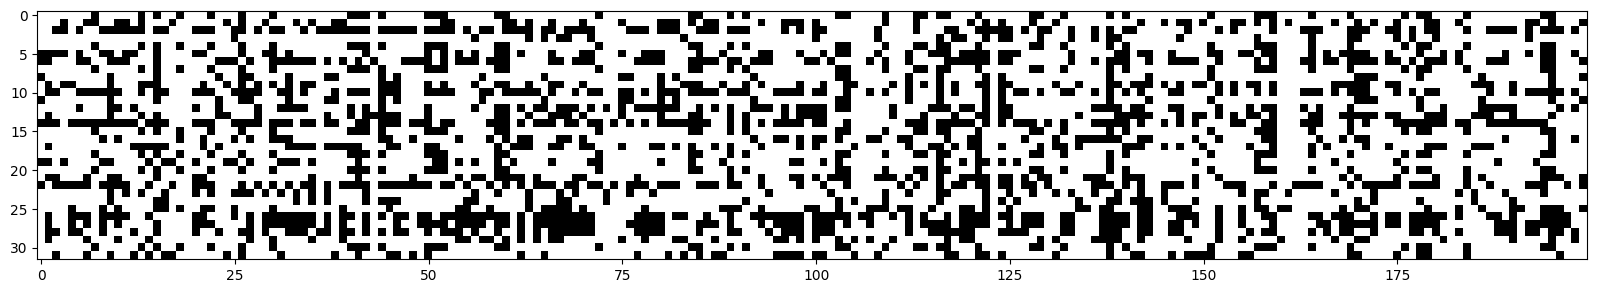

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

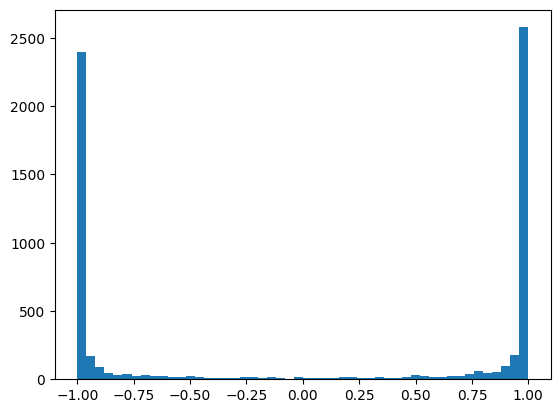

In [32]:
plt.hist(h.view(-1).tolist(), 50);

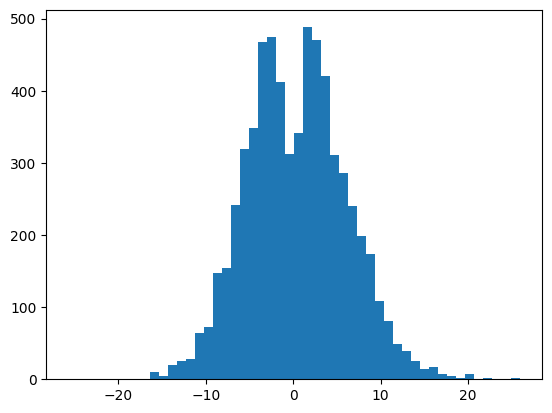

In [34]:
plt.hist(h_preact.view(-1).tolist(), 50);

# Batch Normalization
---
- To control the values of the hidden states, normalize them to be Gaussian.
- The aim is to have hidden states which are roughly Gaussian at initialization, but have the freedom to move around in accordance with backpropagation.
- To allow the distribution of hidden states to change, we introduce `gain` $\gamma$ and `bias` $\beta$ as parameters of the network to be optimized.
- BatchNorm negates the effect of biases used in Linear/ Conv layers before it, and it implements the bias factor through parameter $\beta$.
- Usually appended after `nn.Linear` and `nn.Conv2d` layers to control the scale of layer outputs.

---
## Side Effects
- By normalizing the hidden states, we mathematically couple the values of all the inputs in a batch, thereby making each logit a function of all the batch inputs.
- This introduces a regularization effect which positively affects optimization.

In [ ]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
parameters.append(bngain)
parameters.append(bnbias)

In [ ]:
emb = C[X_batch]
embcat = emb.view(emb.shape[0], -1)
h_preact = embcat @ w1 + b1
h_preact = bngain * (h_preact - h_preact.mean(0, keepdim=True)) 
            / h_preact.std(0, keepdim=True) + bnbias
h = torch.tanh(h_preact)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_batch)

## Inference with BatchNorm
---
- At inference, we expect a single input to generate a single output from the network; but our network expects inputs in batches to dynamically normalize the hidden states.
- To resolve this, we calibrate the BatchNorm mean and standard deviation at the end of training to a fixed value. 
- This calibration phase can be integrated with network training, as it doesn't require backpropagation for optimization.

In [41]:
# calibrate batch norm at end of training
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ w1 + b1
    bnmean = h_preact.mean(0, keepdim=True)
    bnstd = h_preact.std(0, keepdim=True)

## BatchNorm Summary

In [43]:
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

In [44]:
h_preact = embcat @ w1

# BatchNorm layer
bnmeani = h_preact.mean(0, keepdim=True)
bnstdi = h_preact.std(0, keepdim=True)
h_preact = bngain * (h_preact - bnmeani) / bnstdi + bnbias
with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

# PyTorchify

In [52]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=gen) / in_features**0.5
        self.bias = torch.randn(out_features) if bias else None
        
    def __call__(self, X):
        self.out = X @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [53]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, X):
        if self.training:
            X_mean = X.mean(0, keepdim=True)
            X_var = X.var(0, keepdim=True, unbiased=True)
        else:
            X_mean = self.running_mean
            X_var = self.running_var
        X_hat = (X - X_mean) / torch.sqrt(X_var + self.eps)
        self.out = self.gamma * X_hat + self.beta
        
        # buffer update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * X_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * X_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [54]:
class Tanh:
    def __call__(self, X):
        self.out = torch.tanh(X)
        return self.out
    
    def parameters(self):
        return []

In [104]:
n_embed = 10
n_hidden = 100
gen = torch.Generator().manual_seed(seed)

C = torch.randn((vocab_size, n_embed), generator=gen)

layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [105]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=gen)
    X_batch, y_batch = X_train[idx], y_train[idx]
    
    # forward pass
    emb = C[X_batch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

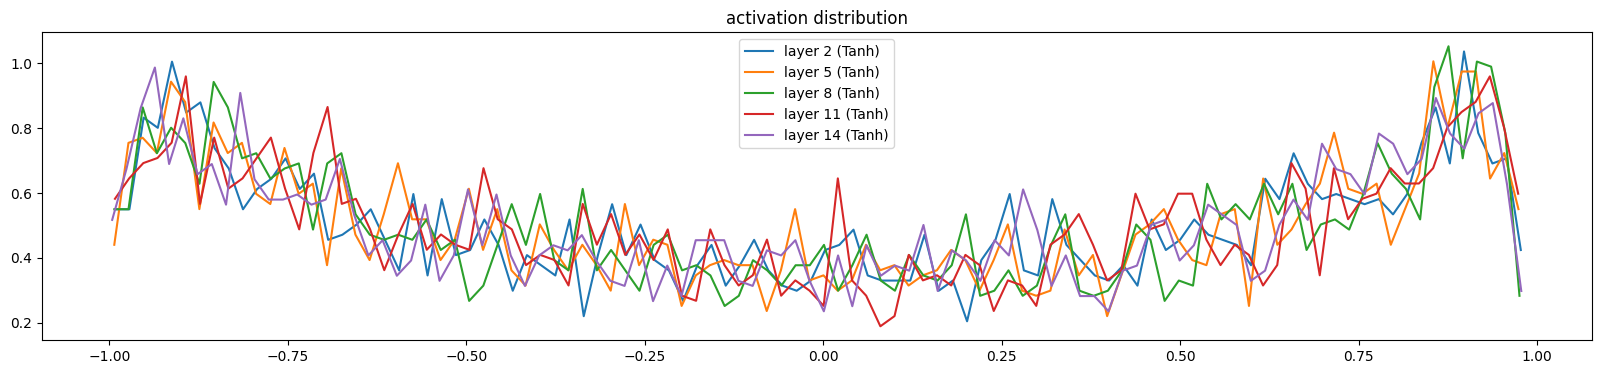

In [106]:
# visualize histogram 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.860915e-03
layer 5 (      Tanh): mean +0.000000, std 3.310030e-03
layer 8 (      Tanh): mean +0.000000, std 3.105929e-03
layer 11 (      Tanh): mean -0.000000, std 2.750410e-03
layer 14 (      Tanh): mean +0.000000, std 2.485619e-03


Text(0.5, 1.0, 'gradient distribution')

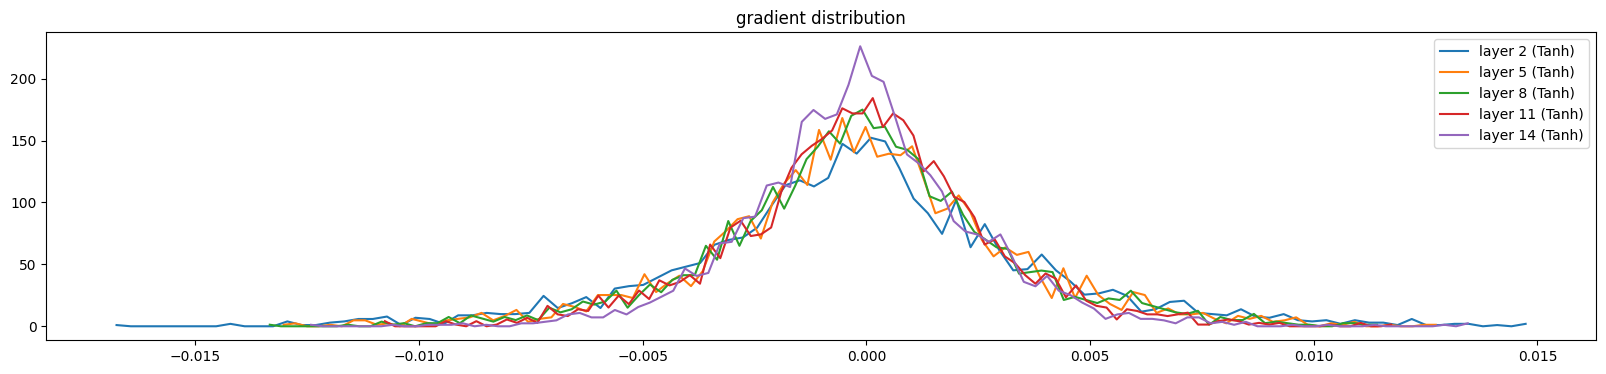

In [107]:
# visualize histogram 
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('gradient distribution')

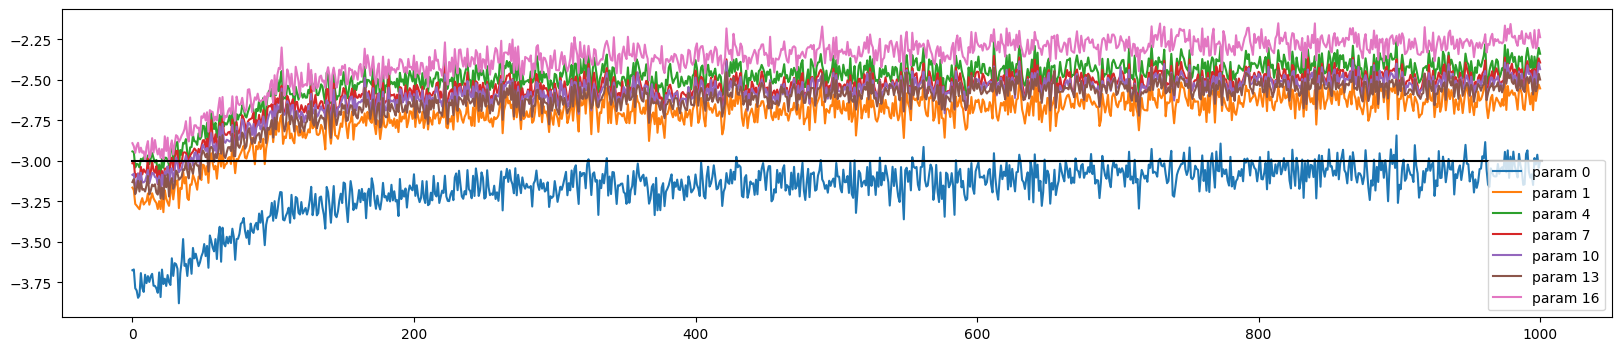

In [108]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # ideal ratio ~1e-3
plt.legend(legends)

# References
---
- [YouTube](https://www.youtube.com/watch?v=P6sfmUTpUmc)
- [GitHub](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb)